# A/B Testing Analysis — Control vs. Test Marketing Campaign

## Introduction, motivation, and business recommendation

### Motivation
I have experience working with data related to customer growth, retention, and call campaigns supporting growth and retention initiatives.

For this project, I wanted to:
* Build on my customer analytics experience by applying another common analytical lens
* Simulate a realistic A/B testing workflow
* Practice a common decision-making framework used in product analytics

### Dataset Description
A/B testing helps businesses identify more effective strategies for acquiring customers, marketing products, increasing reach, and improving conversions.

The dataset contains daily performance metrics for two marketing campaigns: a **Control Campaign** and **Test Campaign**.

Given the data that's available, we will evaluate whether the Test Campaign improved three metrics: **Click-through Rate (CTR)**, **Add-to-Cart Rate**, and **Purchase Rate**. In additional to assessing statistical signfiicant, we will also consider practical effects and cost-effectiveness.

### Business Recommendation
**The business should adopt the Test Campaign to generate more purchases per impression.** The Test Campaign led to a Purchase Rate of 0.7% versus 0.48% for the Control Campaign, a lift of 47%. The primary mechanism was increasing the Click-through Rate (CTR) by almost 70%. Spend per Purchase was 14% higher in the Test Campaign, but this is likely justified because of the higher Purchase Rate.

However, before full rollout, additional considerations include:
* Comparing revenue, not just number of purchases
* Evaluating total spend constraints for future campaigns
* Investigating opportunities to improve the Add-to-Cart Rate, which was not materially impacted by the experiment; consider UI improvements that encourage customers to add items to their cart

## 0. Download data via API

In [ ]:
import os
import zipfile
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate the Kaggle API
api = KaggleApi()
api.authenticate()

# Dataset info
dataset = "amirmotefaker/ab-testing-dataset"
download_path = "ab_testing_data"

# Create directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Download the dataset
api.dataset_download_files(dataset, path=download_path, unzip=True)

# Load the CSV files
control_df = pd.read_csv(os.path.join(download_path, "control_group.csv"))
test_df = pd.read_csv(os.path.join(download_path, "test_group.csv"))

Dataset URL: https://www.kaggle.com/datasets/amirmotefaker/ab-testing-dataset
  Campaign Name;Date;Spend [USD];# of Impressions;Reach;# of Website Clicks;# of Searches;# of View Content;# of Add to Cart;# of Purchase
0  Control Campaign;1.08.2019;2280;82702;56930;70...                                                                                      
1  Control Campaign;2.08.2019;1757;121040;102513;...                                                                                      
2  Control Campaign;3.08.2019;2343;131711;110862;...                                                                                      
3  Control Campaign;4.08.2019;1940;72878;61235;30...                                                                                      
4             Control Campaign;5.08.2019;1835;;;;;;;                                                                                      
  Campaign Name;Date;Spend [USD];# of Impressions;Reach;# of Website Clicks;# of Searche

## 1. Load libraries
* Pandas for cleaning and transforming the data
* Numpy for any numeric transformations and calculations
* Scipy and Statsmodels for perfmorning the A/B tests
* Matplotlib and Seaborn for data viz

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

## 2. Import control and test data

In [ ]:
control = pd.read_csv("C:\\Users\\Lenovo\\Documents\\AB Testing Project\\ab_testing_data\\control_group.csv", sep=';')
test = pd.read_csv("C:\\Users\\Lenovo\\Documents\\AB Testing Project\\ab_testing_data\\test_group.csv", sep=';')

In [3]:
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


## 3. Data cleaning

In [5]:
# Make sure columns are the same data types in both datasets
print(control.dtypes)
print(test.dtypes)

Campaign Name           object
Date                    object
Spend [USD]              int64
# of Impressions       float64
Reach                  float64
# of Website Clicks    float64
# of Searches          float64
# of View Content      float64
# of Add to Cart       float64
# of Purchase          float64
dtype: object
Campaign Name          object
Date                   object
Spend [USD]             int64
# of Impressions        int64
Reach                   int64
# of Website Clicks     int64
# of Searches           int64
# of View Content       int64
# of Add to Cart        int64
# of Purchase           int64
dtype: object


In [4]:
# Convert numeric columns in the test data to float; do the same for Spend in the control data
test[test.columns[test.dtypes == 'int64']] = test[test.columns[test.dtypes == 'int64']].astype(float)
print(test.dtypes)

control['Spend [USD]'] = control['Spend [USD]'].astype(float)
print(control.dtypes)

Campaign Name           object
Date                    object
Spend [USD]            float64
# of Impressions       float64
Reach                  float64
# of Website Clicks    float64
# of Searches          float64
# of View Content      float64
# of Add to Cart       float64
# of Purchase          float64
dtype: object
Campaign Name           object
Date                    object
Spend [USD]            float64
# of Impressions       float64
Reach                  float64
# of Website Clicks    float64
# of Searches          float64
# of View Content      float64
# of Add to Cart       float64
# of Purchase          float64
dtype: object


In [5]:
# Look for missing values
control[control.isna().any(axis=1)]

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
4,Control Campaign,5.08.2019,1835.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test[test.isna().any(axis=1)]

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase


### The control set has one row with missing values (Date = 5.08.2019). Can we impute the values by regressing the non-missing values on the Spend field?

In [7]:
# Check if Spend is predictive of any of the campaign metrics

control_no_na = control.dropna(axis=0) # drop missing row

data = control_no_na.drop(['Campaign Name', 'Date'],axis=1)
X = sm.add_constant(data.drop(['Spend [USD]'],axis=1))
y=data['Spend [USD]']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Spend [USD]   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                    0.7724
Date:                Sun, 15 Feb 2026   Prob (F-statistic):              0.617
Time:                        12:15:49   Log-Likelihood:                -208.30
No. Observations:                  29   AIC:                             432.6
Df Residuals:                      21   BIC:                             443.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1568.2272    

### Spend is not a good predictor of any campaign metrics, so we should use a different method to handle the row with missing values. 
### Because it's only one row, we'll delete it. This way, we will avoid introducing bias, which could skew the results of our A/B test later.

In [8]:
idx = control.isna().any(axis=1)
control = control[~idx]
test = test[~idx]

control[control.isna().any(axis=1)] # confirm no more missing data

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase


## 4. Data exploration
Key questions:
* Do metrics vary significantly between weekdays and weekends?
* Is spend significantly higher in the test campaign vs. the control campaign?
* Are there any outliers we should be aware of?

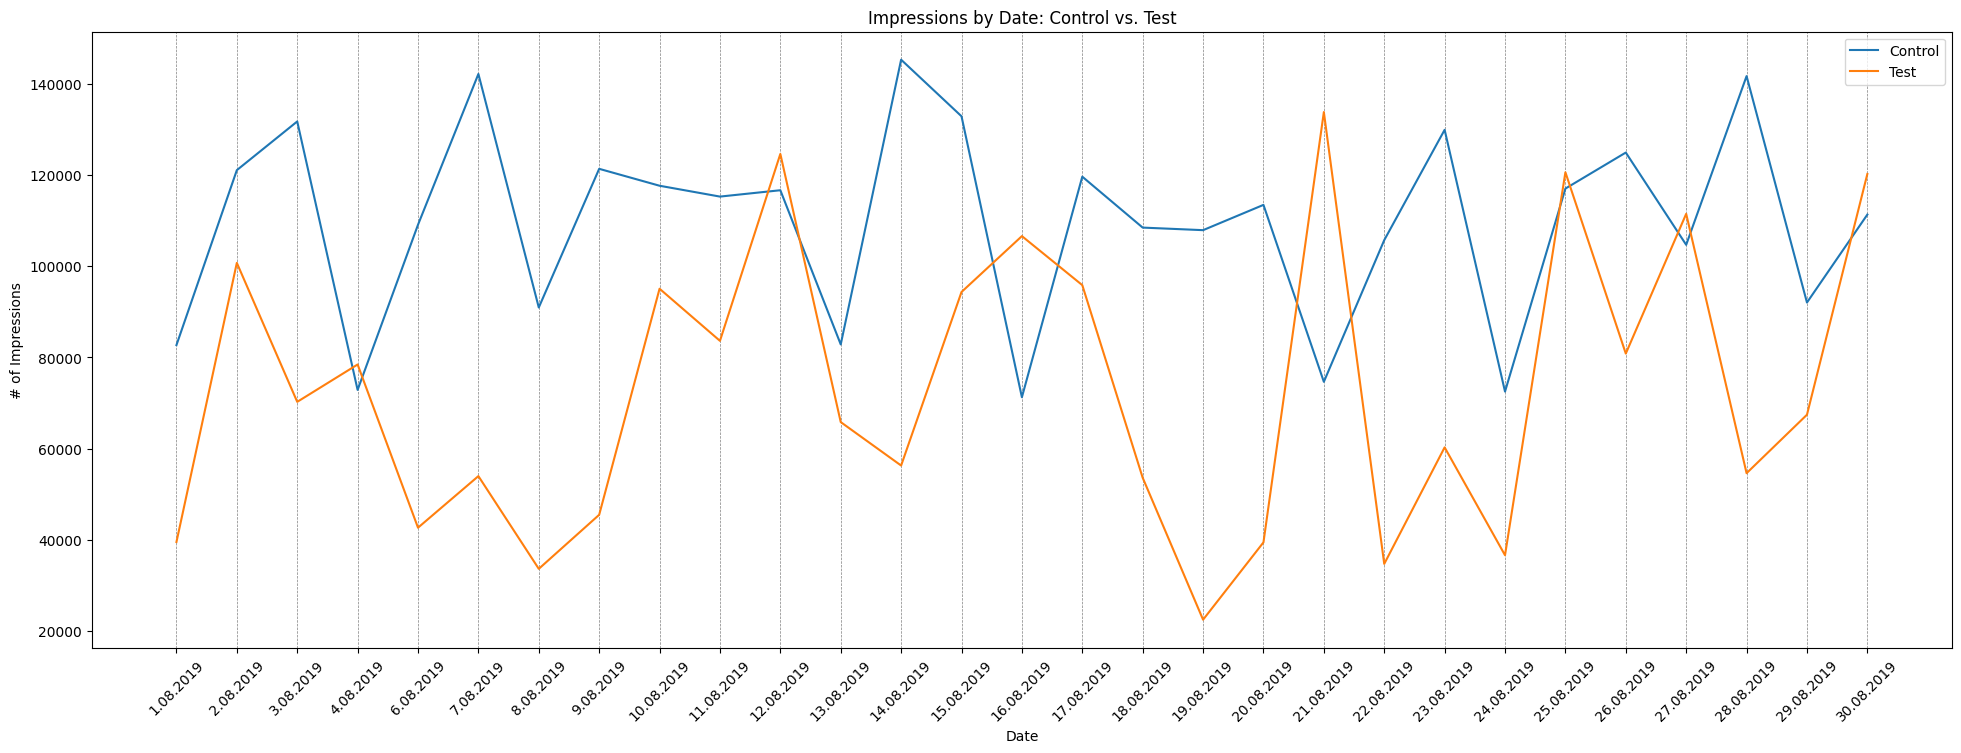

In [ ]:
# compare control and test impressions by day

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=control, x='Date', y='# of Impressions', label='Control')
sns.lineplot(data=test, x='Date', y='# of Impressions', label='Test')
ax.tick_params(axis='x', labelrotation=45)
plt.grid(axis='x', linestyle='--', color='gray', linewidth=0.5)
plt.title('Impressions by Date: Control vs. Test')
plt.show();

Observations:
* Impressions are generally higher in the control group
* Impressions in the control group spike on Wednesdays (7th, 14th, and 28th)
* On the 21st, impressions in the test group spiked while they dipped in the control group, bucking the trend. Were the control/test observations switched on this day?
* No discernible pattern in the test group

Takeaways:
* No need to account for day of the week in our analysis, but the data points on the 21st seem questionable and warrant a closer look

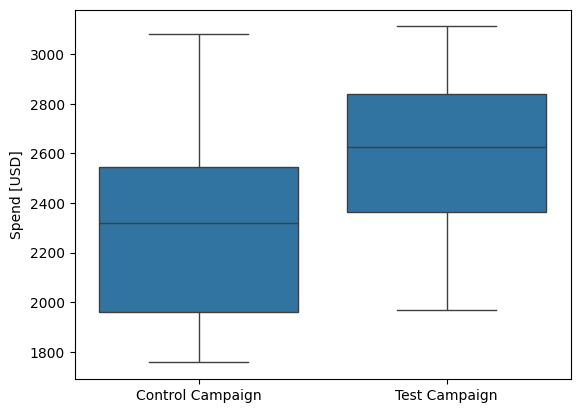

In [ ]:
# compare spend in control and test campaigns
df = pd.concat([control, test], axis=0)
sns.boxplot(data=df, x='Campaign Name', y='Spend [USD]')
plt.xlabel('')
plt.show();

Observations:
* The test campaign is costlier than the control (median daily spend $2,600 vs. $2,300)
* 75% of days in the test campaign were costlier than the typical day in the control campaign

Takeaways:
* Even if the test campaign results in more purchases, higher CTR, etc., we should consider the test campaign's higher spend before making a business recommendation. Results from the test campaign should be especially strong to justify the costlier campaign.

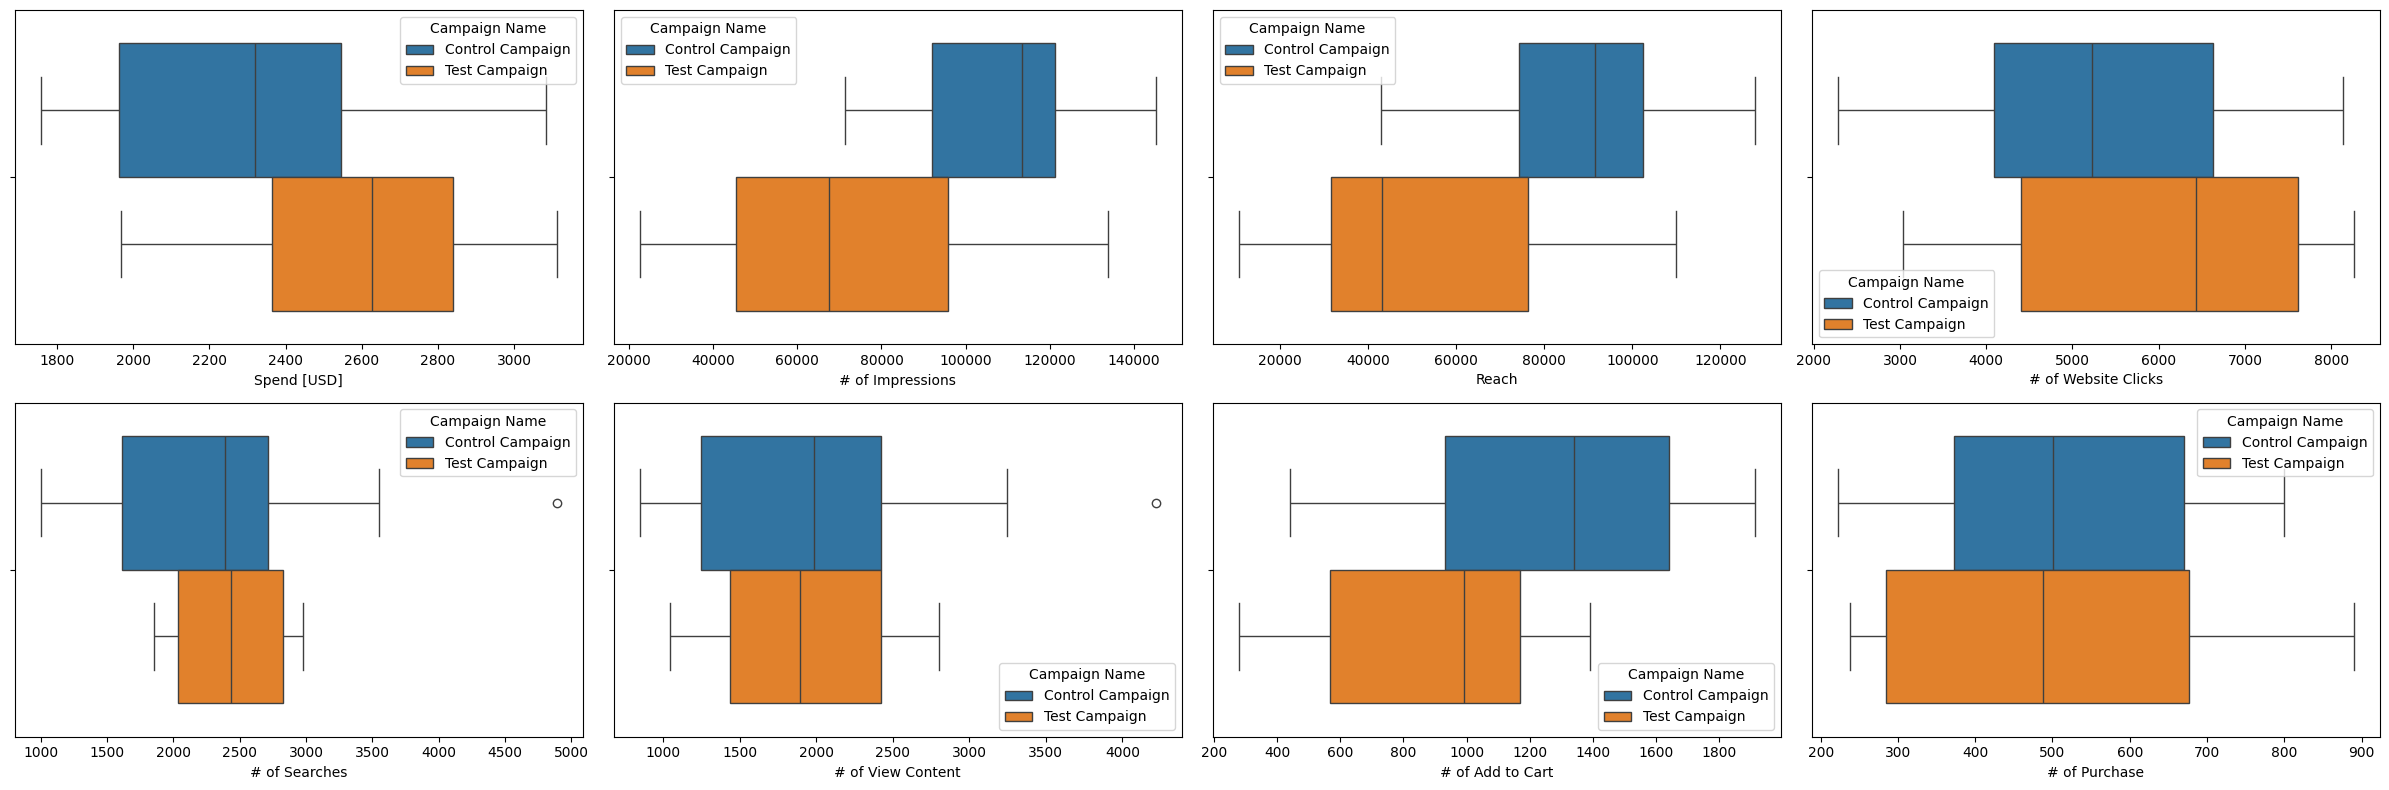

In [ ]:
# check for outliers
df = pd.concat([control, test], axis=0)
cols = df.columns[2:10]
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(24,8))
axs = axs.flatten()
for i, c in enumerate(cols):
    sns.boxplot(data=df, x=c, hue='Campaign Name', ax=axs[i])
plt.tight_layout()
plt.show();

In [75]:
# look into the two outliers
control.loc[control['# of Searches'].idxmax()]

Campaign Name          Control Campaign
Date                         29.08.2019
Spend [USD]                      2375.0
# of Impressions                92029.0
Reach                           74192.0
# of Website Clicks              8127.0
# of Searches                    4891.0
# of View Content                4219.0
# of Add to Cart                 1486.0
# of Purchase                     334.0
Name: 28, dtype: object

In [72]:
control.sort_values('# of Searches', ascending=False)['# of Searches'].head()

28    4891.0
26    3549.0
21    3102.0
7     3047.0
10    2941.0
Name: # of Searches, dtype: float64

In [76]:
control.loc[control['# of View Content'].idxmax()]

Campaign Name          Control Campaign
Date                         29.08.2019
Spend [USD]                      2375.0
# of Impressions                92029.0
Reach                           74192.0
# of Website Clicks              8127.0
# of Searches                    4891.0
# of View Content                4219.0
# of Add to Cart                 1486.0
# of Purchase                     334.0
Name: 28, dtype: object

In [78]:
control.sort_values('# of View Content', ascending=False)['# of View Content'].head()

28    4219.0
26    3249.0
21    2988.0
7     2746.0
20    2496.0
Name: # of View Content, dtype: float64

Observations:
* There are two outliers in the control campaign, one in # of Searches and one in # of View Content. They occurred on the same day, 29.08.2019. The test campaign doesn't have any outliers.
* The control campaign generally resulted in more impressions, reach, and adds to cart. The test campaign generally resulted in more website clicks while having higher spend. It doesn't look like there was a meaningful difference in the # of searches, # of content views, or # of purchases.

Takeaways:
* The two outliers aren't necessarily a problem, but we should keep them in mind and revisit them if any metrics involving # of Searches or # of View Content end up being significant in our A/B test.
* The boxplots give us a general sense that the test campaign did not result in more purchases, but it still might have had more success with moving customers through other steps of the funnel, e.g., click-through rate. A formal significance test will give us a better idea.

## 5. Define success metrics

We'll name a few success metrics describing different stages of the customer funnel:
1. **Click-through Rate (CTR)** = [# of Website Clicks] / [# of Impressions]: Measures campaign's ability to generate interest in the website
2. **Add-to-Cart Rate** = [# of Add to Cart] / [# of Impressions]:  Measures campaign's ability to generate desire for products on the website
3. **Purchase Rate** = [# of Purchase] / [# of Impressions]: Measures campaign's ability to generate purchases, the ultimate goal of the campaign
4. (Post-hoc): **Spend per Purchase** = [Spend] / [# of Purchase]: Measures practical interpretation of the A/B test. Even if the test campaign increases purchases, is it cost-effective?

Because our sample size is large (over 2 million impressions in the test group), we'll evaluate the results of our A/B test with a Z-test. We will also consider practical effect sizes, since at a sample size this large a small lift in any of our metrics could be statistically significant. 

Also, because testing multiple metrics inflates the chance of a false positive (Type I error), we will assign a primary metric and let the other two be secondary diagnostic metrics. **Purchase Rate** will be our primary metric, since the ultimate goal of the campaign is to increase purchases.

The baseline purchase rate for the control campaign is 0.48%. We will only recommend the test campaign if it creates a **25% lift in purchases -- an absolute purchase rate of 0.6% or higher**.

For **Spend per Purchase**, we won't run a statistical test, but we'll use it to interpret the results of our analysis. The baseline Spend per Purchase for the control campaign is $4.41. If the test campaign achieves the first goal of increasing purchase rate by 25%, we will only recommend it if the Spend per Purchase is **less than 25% higher -- an absolute Spend per Purchase of $5.51 or less**.

## 6. Hypothesis test

For **CTR**, **Add-to-Cart Rate**, and **Purchase Rate**, let  
- $p_T$ = proportion for the **test** campaign  
- $p_C$ = proportion for the **control** campaign 

We are testing whether the test campaign has a higher click-through, add-to-cart, or purchase rate than the control campaign.

### Null Hypothesis
$$
H_0: p_T <= p_C
$$

### Alternative Hypothesis
$$
H_A: p_T > p_C
$$

This is a **one-sided (right-tailed)** hypothesis test. We will test at a 5% significance level, but we will also consider practical effect sizes as outlined above.

## 7. Statistical analysis

#### Create helper functions and aggregate data before testing metrics

In [ ]:
def ztest(success_A, obs_A, success_B, obs_B, alpha):
    pA = success_A/obs_A
    pB = success_B/obs_B
    effect = (pA-pB)/pB
    success = np.array([success_A, success_B])
    obs = np.array([obs_A, obs_B])
    stat, pval = proportions_ztest(success, obs, value=0, alternative='larger')
    return stat, pval, pval < alpha, pA, pB, effect

In [26]:
# aggregate data first
metric_cols = ['# of Impressions', '# of Website Clicks', '# of Add to Cart', '# of Purchase', 'Spend [USD]']

control_agg = control[metric_cols].sum()
test_agg = test[metric_cols].sum()

#### Primary test: Purchase Rate

In [12]:
pur_stat, pur_pval, pur_sig, pur_pA, pur_pB, pur_effect = ztest(
    test_agg['# of Purchase'], test_agg['# of Impressions'],
    control_agg['# of Purchase'], control_agg['# of Impressions'],
    alpha = 0.05
)

print(f'Purchase Rate: \n Test % = {np.round(100*pur_pA,2)} \n Control % = {(np.round(100*pur_pB,2))} \n Effect Size: {np.round(100*pur_effect,2)} \n z-stat = {pur_stat}\n p-value = {pur_pval}\n significant? {pur_sig}')

Purchase Rate: 
 Test % = 0.7 
 Control % = 0.48 
 Effect Size: 46.76 
 z-stat = 33.5364141560123
 p-value = 7.103042483417265e-247
 significant? True


Purchase Rate is significantly higher for the test campaign (0.7%) vs. the control campaign (0.48%). It has an effect size of 46.76%, higher than our target of 25%.

#### Secondary test #1: Click-through Rate

In [21]:
ctr_stat, ctr_pval, ctr_sig, ctr_pA, ctr_pB, ctr_effect = ztest(
    test_agg['# of Website Clicks'], test_agg['# of Impressions'],
    control_agg['# of Website Clicks'], control_agg['# of Impressions'],
    alpha = 0.05
)

print(f'Click-through Rate: \n Test % = {np.round(100*ctr_pA,2)} \n Control % = {(np.round(100*ctr_pB,2))} \n Effect Size: {np.round(100*ctr_effect,2)} \n z-stat = {ctr_stat}\n p-value = {ctr_pval}\n significant? {ctr_sig}')

Click-through Rate: 
 Test % = 8.25 
 Control % = 4.86 
 Effect Size: 69.82 
 z-stat = 158.4405308420443
 p-value = 0.0
 significant? True


#### Secondary test #2: Add-to-Cart Rate

In [22]:
acr_stat, acr_pval, acr_sig, acr_pA, acr_pB, acr_effect = ztest(
    test_agg['# of Add to Cart'], test_agg['# of Impressions'],
    control_agg['# of Add to Cart'], control_agg['# of Impressions'],
    alpha = 0.05
)

print(f'Add-to-Cart Rate: \n Test % = {np.round(100*acr_pA,3)} \n Control % = {(np.round(100*acr_pB,2))} \n Effect Size: {np.round(100*acr_effect,2)} \n z-stat = {acr_stat}\n p-value = {acr_pval}\n significant? {acr_sig}')

Add-to-Cart Rate: 
 Test % = 1.201 
 Control % = 1.19 
 Effect Size: 1.18 
 z-stat = 1.4502025569986254
 p-value = 0.07350102111991884
 significant? False


Click-through Rate is significantly higher for the test campaign (8.25%) vs. the control campaign (4.86%). It has an effect size of 69.82%. This is consistent with the Purchase Rate being higher for the test campaign.

Add-to-Cart Rate is not significantly higher for the test campaign. The effect size is only 1.18%. This implies that the test campaign generates a higher conversion rate between customers adding items to their cart and making purchases.

#### Post-hoc analysis: Spend per Purchase

In [ ]:
control_spp = control_agg['Spend [USD]'] / control_agg['# of Purchase']
test_spp = test_agg['Spend [USD]'] / test_agg['# of Purchase']

print(f'Spend per Purchase: \n Test = ${np.round(test_spp,2)} \n Control = ${np.round(control_spp,2)} \n Effect Size: {np.round(100*(test_spp - control_spp)/control_spp,2)}%')

Spend per Purchase: 
 Test = $5.02 
 Control = $4.41 
 Effect Size: 13.83%


Spend per Purchase is higher for the test campaign ($5.02) than the control campaign ($4.41), but the difference is only 13.83%. That's less than the benchmark we established before conducting our analysis, so we can conclude that the test campaign is cost-effective.

## 8. Reporting and visualizations

#### Experiment Results: CTR, Add-to-Cart Rate, and Purchase Rate by campaign

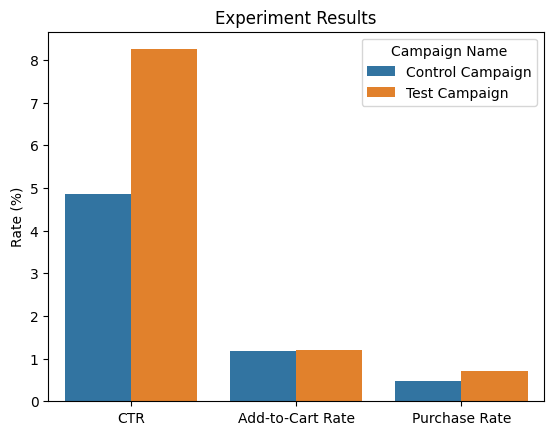

In [90]:
df_control = control[metric_cols]
df_test = test[metric_cols]

def aggregate_metrics(df):
    agg = df.sum()

    return {
        "impressions": agg["# of Impressions"],
        "CTR": 100 * agg["# of Website Clicks"] / agg["# of Impressions"],
        "Add-to-Cart Rate": 100 * agg["# of Add to Cart"] / agg["# of Impressions"],
        "Purchase Rate": 100 * agg["# of Purchase"] / agg["# of Impressions"],
        "Spend per Purchase": agg["Spend [USD]"] / agg["# of Purchase"]
    }

control_metrics = aggregate_metrics(df_control)
test_metrics = aggregate_metrics(df_test)

summary_df = pd.DataFrame([control_metrics, test_metrics],
                          index=["Control Campaign", "Test Campaign"])

def proportion_ci(successes, n, z=1.96):
    p = successes / n
    se = np.sqrt(p * (1 - p) / n)
    return p - z * se, p + z * se

ci_data = []

for label, df in [("Control Campaign", df_control), ("Test Campaign", df_test)]:
    agg = df.sum()

    for metric, col in [
        ("CTR", "# of Website Clicks"),
        ("Add-to-Cart Rate", "# of Add to Cart"),
        ("Purchase Rate", "# of Purchase")
    ]:
        low, high = proportion_ci(agg[col], agg["# of Impressions"])
        ci_data.append([label, metric, low, high])

ci_df = pd.DataFrame(ci_data, columns=["Campaign Name", "Metric", "CI Low", "CI High"])

plot_df = summary_df.reset_index().melt(
    id_vars="index",
    value_vars=["CTR", "Add-to-Cart Rate", "Purchase Rate"],
    var_name="Metric",
    value_name="Rate"
).rename(columns={"index": "Campaign Name"})

plot_df = plot_df.merge(ci_df, on=["Campaign Name", "Metric"])

plt.figure()
sns.barplot(data=plot_df, x="Metric", y="Rate", hue="Campaign Name")
plt.title("Experiment Results")
plt.ylabel('Rate (%)')
plt.xlabel('')
plt.show()


#### Relative Lift vs. Control

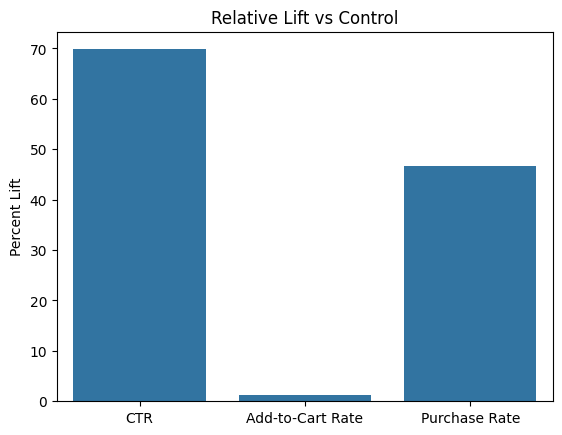

In [92]:
lift_df = []

for metric in ["CTR", "Add-to-Cart Rate", "Purchase Rate"]:
    lift = 100 * (
        summary_df.loc["Test Campaign", metric] -
        summary_df.loc["Control Campaign", metric]
    ) / summary_df.loc["Control Campaign", metric]
    lift_df.append([metric, lift])

lift_df = pd.DataFrame(lift_df, columns=["Metric", "Lift"])


plt.figure()
sns.barplot(data=lift_df, x="Metric", y="Lift")
plt.title("Relative Lift vs Control")
plt.ylabel("Percent Lift")
plt.xlabel('')
plt.show()

The test campaign resulted in a 70% lift in the CTR and a 47% lift in the Purchase Rate. There was not a significant lift in the Add-to-Cart Rate. 

#### Funnel Analysis: Where did the test campaign make the most difference?

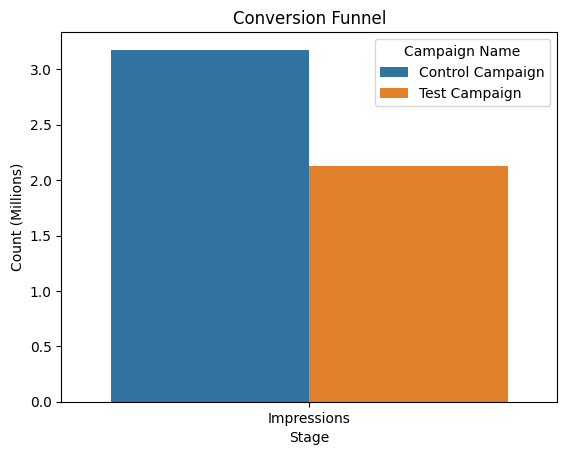

In [95]:
funnel = pd.DataFrame({
    "Stage": ["Impressions", "Clicks", "Adds to Cart", "Purchases"],
    "Control Campaign": df_control.sum()[["# of Impressions", "# of Website Clicks", "# of Add to Cart", "# of Purchase"]].values,
    "Test Campaign": df_test.sum()[["# of Impressions", "# of Website Clicks", "# of Add to Cart", "# of Purchase"]].values
})

funnel_df = funnel.melt(id_vars="Stage", var_name="Campaign Name", value_name="Count")
funnel_df.loc[funnel_df["Stage"] == "Impressions", 'Count'] = funnel_df.loc[funnel_df["Stage"] == "Impressions", 'Count'] / 1_000_000  # scale down for better visualization

plt.figure()
sns.barplot(data=funnel_df.loc[funnel_df["Stage"] == "Impressions"], x="Stage", y="Count", hue="Campaign Name")
plt.title("Conversion Funnel")
plt.ylabel("Count (Millions)")
plt.show()


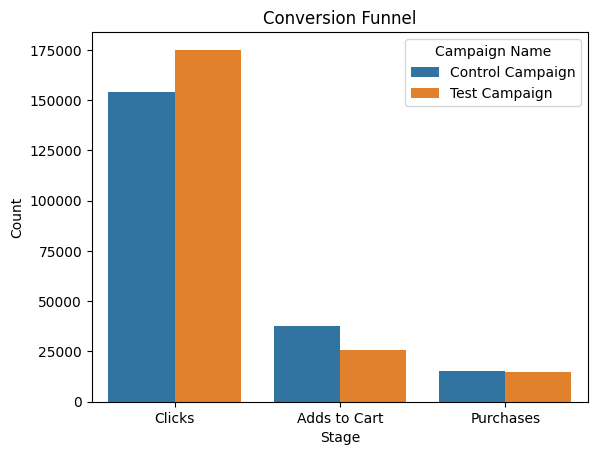

In [ ]:
plt.figure()
sns.barplot(data=funnel_df.loc[funnel_df["Stage"] != "Impressions"], x="Stage", y="Count", hue="Campaign Name")
plt.title("Conversion Funnel")
plt.show()

There were more impressions in the control campaign by about 1 million, but the test campaign generated about as many purchases. Higher clicks were the main driver of the lift in purchases: despite having fewer impressions, the test campaign generated 25k more clicks.

#### Quality Check: Did the Purchase Rate vary significantly by day of the campaign?

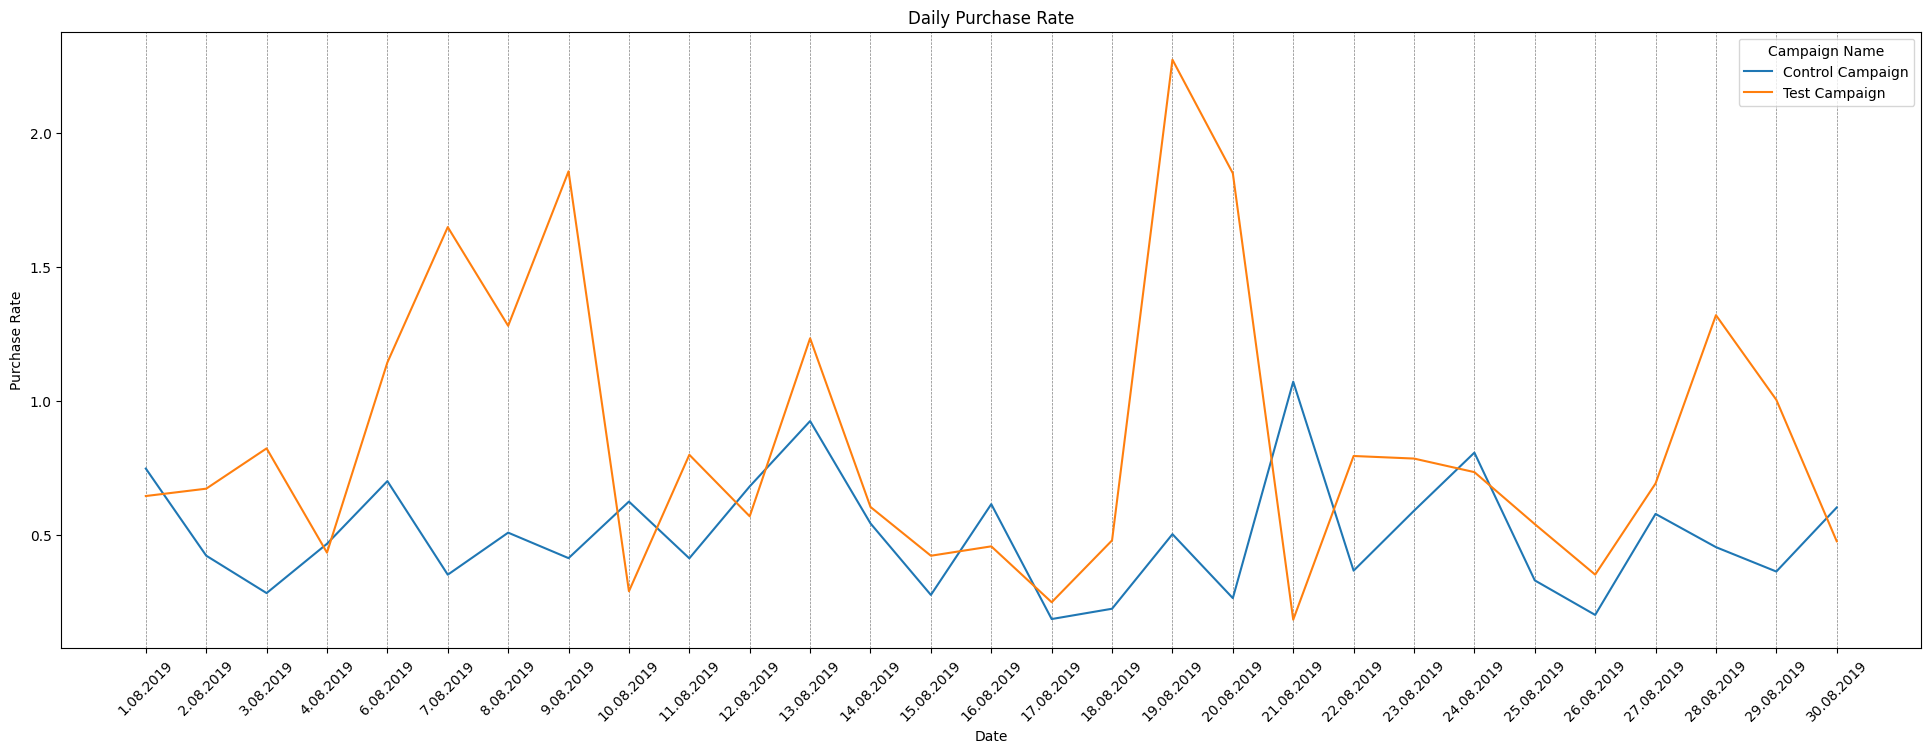

In [87]:
def add_daily_rates(df, label):
    df = df.copy()
    df = pd.concat([df, control['Date']], axis=1)
    df["Campaign Name"] = label
    df["CTR"] = df["# of Website Clicks"] / df["# of Impressions"]
    df["Add-to-Cart Rate"] = df["# of Add to Cart"] / df["# of Impressions"]
    df["Purchase Rate"] = 100 * df["# of Purchase"] / df["# of Impressions"]
    df['Day of the Week'] = pd.to_datetime(df['Date'], format='%d.%m.%Y').dt.day_name()
    return df

daily_df = pd.concat([
    add_daily_rates(df_control, "Control Campaign"),
    add_daily_rates(df_test, "Test Campaign")
])

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=daily_df, x="Date", y="Purchase Rate", hue="Campaign Name")
ax.tick_params(axis='x', labelrotation=45)
plt.grid(axis='x', linestyle='--', color='gray', linewidth=0.5)
plt.title("Daily Purchase Rate")
plt.show()


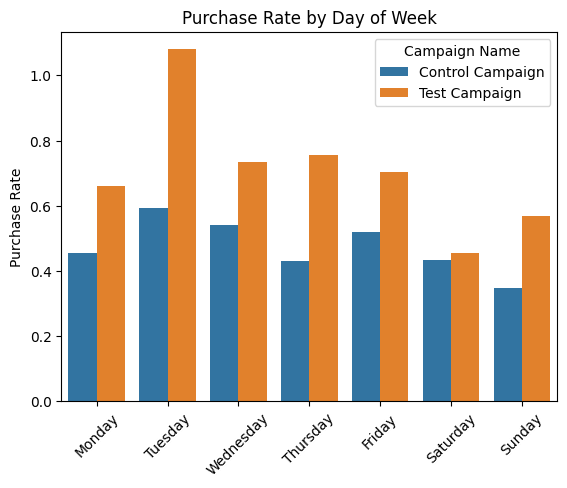

In [93]:
dow_summary = (
    daily_df
    .groupby(["Campaign Name", "Day of the Week"], as_index=False)
    .agg({
        "# of Purchase": "sum",
        "# of Impressions": "sum"
    })
)

dow_summary["Purchase Rate"] = (
    100 * dow_summary["# of Purchase"] / dow_summary["# of Impressions"]
)

day_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

dow_summary["Day of the Week"] = pd.Categorical(
    dow_summary["Day of the Week"],
    categories=day_order,
    ordered=True
)

plt.figure()
sns.barplot(
    data=dow_summary,
    x="Day of the Week",
    y="Purchase Rate",
    hue="Campaign Name"
)

plt.title("Purchase Rate by Day of Week")
plt.ylabel("Purchase Rate")
plt.xlabel("")
plt.xticks(rotation=45)
plt.show()


Both the control and test campaigns saw lower purchase rates on the weekend. Purchase rates in the test campaign were much higher on Tuesdays (by almost 100% relative to the control campaign), driven in large part by an outlier on 8/19 that warrants closer inspection. Overall, purchase rates were consistently higher in the test campaign, outperforming the control campaign on 21 out of 29 days.

#### Practical Consideration: Cost Efficiency Comparison

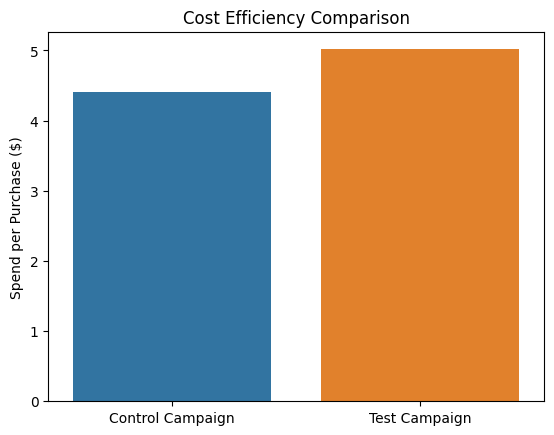

In [79]:
spend_df = summary_df.reset_index()[["index", "Spend per Purchase"]]
spend_df.columns = ["Campaign Name", "Spend per Purchase ($)"]

plt.figure()
sns.barplot(data=spend_df, x="Campaign Name", y="Spend per Purchase ($)", hue="Campaign Name")
plt.title("Cost Efficiency Comparison")
plt.xlabel("")
plt.show()

Spend per Purchase was about 14% higher in the test campaign, which is a reasonable increase to generate a 47% lift in Purchase Rate. However, the practical implications of this increase depend on the size of future ad campaigns (which will impact total spend) and the revenue accrued through those campaigns (which will impact total revenue).